### Import Required Libraries

In [1]:
import os

# Data handling and preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model and evaluation
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Visualization (optional, but helpful for diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# Logging for debugging
import logging

# Set up logging (only once)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features (NCA)

In [2]:
import pandas as pd
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File paths
file_paths = {
    "nca": "../results/nca_results.csv",  # Updated path for NCA-selected features
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load NCA selected features
def load_nca_features(file_path, num_features=10):
    if os.path.exists(file_path):
        nca_data = pd.read_csv(file_path)

        # Ensure the required column exists
        if "Feature" in nca_data.columns:
            selected_features = nca_data["Feature"].tolist()[:num_features]  # Select top N features
            logging.info(f"Loaded top {num_features} NCA features.")
            return selected_features
        else:
            raise ValueError(f"Expected column 'Feature' not found in {file_path}. Ensure it contains the selected miRNAs.")
    else:
        raise FileNotFoundError(f"NCA feature selection file not found: {file_path}")


# Load processed data
if os.path.exists(file_paths["processed_data"]):
    processed_data = pd.read_csv(file_paths["processed_data"])
else:
    raise FileNotFoundError(f"Processed data file missing: {file_paths['processed_data']}")

# Select top NCA features
num_features_to_select = 500  # Change as needed
top_features = load_nca_features(file_paths["nca"], num_features=num_features_to_select)

# Ensure only valid miRNA features are selected (remove metadata like 'stage' and 'subtype' if present)
filtered_features = [feature for feature in top_features if feature.startswith("hsa-mir-")]

# Ensure the selected miRNAs are in the processed dataset
available_features = [feature for feature in filtered_features if feature in processed_data.columns]

# Final Check: Ensure count matches actual miRNAs displayed
logging.info(f"Total valid miRNAs used in classification: {len(available_features)}")

# Display selected miRNAs
print("\nSelected miRNAs for Classification:")
for i, miRNA in enumerate(available_features, 1):
    print(f"{i}. {miRNA}")

# Save cleaned miRNAs to a new CSV file
cleaned_miRNAs_df = pd.DataFrame(available_features, columns=["Selected_miRNAs"])
cleaned_miRNAs_df.to_csv("../results/cleaned_nca_miRNAs.csv", index=False)

print("\nProcessing complete. Selected features saved.")

2025-03-09 17:55:00,473 - INFO - Loaded top 500 NCA features.
2025-03-09 17:55:00,474 - INFO - Total valid miRNAs used in classification: 500



Selected miRNAs for Classification:
1. hsa-mir-4271
2. hsa-mir-5572
3. hsa-mir-1471
4. hsa-mir-6770-1
5. hsa-mir-4792
6. hsa-mir-4280
7. hsa-mir-4698
8. hsa-mir-4703
9. hsa-mir-596
10. hsa-mir-8052
11. hsa-mir-3672
12. hsa-mir-4534
13. hsa-mir-5186
14. hsa-mir-4440
15. hsa-mir-5692c-2
16. hsa-mir-4696
17. hsa-mir-6090
18. hsa-mir-3156-2
19. hsa-mir-3665
20. hsa-mir-5700
21. hsa-mir-4321
22. hsa-mir-4310
23. hsa-mir-7843
24. hsa-mir-3135b
25. hsa-mir-1265
26. hsa-mir-5689
27. hsa-mir-4322
28. hsa-mir-6752
29. hsa-mir-378e
30. hsa-mir-593
31. hsa-mir-3972
32. hsa-mir-202
33. hsa-mir-548c
34. hsa-mir-4769
35. hsa-mir-548ax
36. hsa-mir-4327
37. hsa-mir-548p
38. hsa-mir-4530
39. hsa-mir-4264
40. hsa-mir-4418
41. hsa-mir-2392
42. hsa-mir-378j
43. hsa-mir-8089
44. hsa-mir-1184-2
45. hsa-mir-550b-1
46. hsa-mir-548ap
47. hsa-mir-1587
48. hsa-mir-5011
49. hsa-mir-4438
50. hsa-mir-1285-2
51. hsa-mir-7107
52. hsa-mir-1260a
53. hsa-mir-6722
54. hsa-mir-5704
55. hsa-mir-4278
56. hsa-mir-6719
57. hs

### Process Features & Labels for Multi-Output Classification (NCA)

In [3]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Remove rare cases from dataset before train-test split
rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove

# Create a mask to filter out rare cases
filtered_data = processed_data[~processed_data.set_index(["stage", "subtype"]).index.isin(rare_cases)].copy()

# Remove subtype 4 before splitting (since it only has 1 sample)
filtered_data = filtered_data[filtered_data["subtype"] != 4]

# Ensure Diagnosis column is also updated after filtering
filtered_data["diagnosis"] = filtered_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Extract features and target labels again (use NCA-selected features)
expression_values = filtered_data[available_features]  # Ensure only valid NCA features are used

print("\nData shapes before handling missing values:")
print("Expression values shape:", expression_values.shape)

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Remove samples with missing values
valid_indices = ~(expression_values.isnull().any(axis=1))
expression_values = expression_values[valid_indices]
filtered_data = filtered_data.loc[valid_indices]

print("\nData shapes after handling missing values:")
print("Expression values shape:", expression_values.shape)

# SINGLE TRAIN-TEST SPLIT (Applies to ALL Models)
X_train, X_test, y_train, y_test = train_test_split(
    expression_values, filtered_data[["diagnosis", "stage", "subtype"]],
    test_size=0.2, random_state=42, stratify=filtered_data[["diagnosis", "stage", "subtype"]]
)

# Extract labels for each model
y_train_diagnosis, y_test_diagnosis = y_train["diagnosis"], y_test["diagnosis"]
y_train_stage, y_test_stage = y_train["stage"], y_test["stage"]
y_train_subtype, y_test_subtype = y_train["subtype"], y_test["subtype"]

# SCALE FEATURES (Same for all models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

print("\nTraining set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nTraining set class distribution (Stage):")
print(y_train_stage.value_counts())

print("\nTraining set class distribution (Subtype):")
print(y_train_subtype.value_counts())

print("\nTesting set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nTesting set class distribution (Stage):")
print(y_test_stage.value_counts())

print("\nTesting set class distribution (Subtype):")
print(y_test_subtype.value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': available_features
}


Data shapes before handling missing values:
Expression values shape: (1083, 500)

Data shapes after handling missing values:
Expression values shape: (1083, 500)

Updated Train-Test Split Information:
Training set: (866, 500), Testing set: (217, 500)

Training set class distribution (Diagnosis):
diagnosis
1    857
0      9
Name: count, dtype: int64

Training set class distribution (Stage):
stage
1    453
2    246
3    139
4     19
0      9
Name: count, dtype: int64

Training set class distribution (Subtype):
subtype
1    448
2    409
0      9
Name: count, dtype: int64

Testing set class distribution (Diagnosis):
diagnosis
1    215
0      2
Name: count, dtype: int64

Testing set class distribution (Stage):
stage
1    113
2     62
3     35
4      5
0      2
Name: count, dtype: int64

Testing set class distribution (Subtype):
subtype
1    112
2    103
0      2
Name: count, dtype: int64


### Train-Test Split & Feature Scaling (NCA)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Validate Selected Features
print("\nInitial data check:")
print("Top features:", top_features)
print("Number of top features:", len(top_features))

# Ensure selected NCA features exist in the dataset
available_features = [feature for feature in top_features if feature in filtered_data.columns]
if not available_features:
    raise ValueError("No matching features found in processed data for the selected NCA feature set.")

# Filter and Prepare Data
expression_values = filtered_data[available_features]

print("\nData shapes before handling missing values:")
print("Expression values shape:", expression_values.shape)

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Remove samples with missing values
valid_indices = ~(expression_values.isnull().any(axis=1))
expression_values = expression_values[valid_indices]
filtered_data = filtered_data.loc[valid_indices]

print("\nData shapes after handling missing values:")
print("Expression values shape:", expression_values.shape)

# SINGLE TRAIN-TEST SPLIT (Applies to ALL Models)
X_train, X_test, y_train, y_test = train_test_split(
    expression_values, filtered_data[["diagnosis", "stage", "subtype"]],
    test_size=0.2, random_state=42, stratify=filtered_data[["diagnosis", "stage", "subtype"]]
)

# Extract labels for each model
y_train_diagnosis, y_test_diagnosis = y_train["diagnosis"], y_test["diagnosis"]
y_train_stage, y_test_stage = y_train["stage"], y_test["stage"]
y_train_subtype, y_test_subtype = y_train["subtype"], y_test["subtype"]

# SCALE FEATURES (Same for all models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

print("\nTraining set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nTraining set class distribution (Stage):")
print(y_train_stage.value_counts())

print("\nTraining set class distribution (Subtype):")
print(y_train_subtype.value_counts())

print("\nTesting set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nTesting set class distribution (Stage):")
print(y_test_stage.value_counts())

print("\nTesting set class distribution (Subtype):")
print(y_test_subtype.value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': available_features
}


Initial data check:
Top features: ['hsa-mir-4271', 'hsa-mir-5572', 'hsa-mir-1471', 'hsa-mir-6770-1', 'hsa-mir-4792', 'hsa-mir-4280', 'hsa-mir-4698', 'hsa-mir-4703', 'hsa-mir-596', 'hsa-mir-8052', 'hsa-mir-3672', 'hsa-mir-4534', 'hsa-mir-5186', 'hsa-mir-4440', 'hsa-mir-5692c-2', 'hsa-mir-4696', 'hsa-mir-6090', 'hsa-mir-3156-2', 'hsa-mir-3665', 'hsa-mir-5700', 'hsa-mir-4321', 'hsa-mir-4310', 'hsa-mir-7843', 'hsa-mir-3135b', 'hsa-mir-1265', 'hsa-mir-5689', 'hsa-mir-4322', 'hsa-mir-6752', 'hsa-mir-378e', 'hsa-mir-593', 'hsa-mir-3972', 'hsa-mir-202', 'hsa-mir-548c', 'hsa-mir-4769', 'hsa-mir-548ax', 'hsa-mir-4327', 'hsa-mir-548p', 'hsa-mir-4530', 'hsa-mir-4264', 'hsa-mir-4418', 'hsa-mir-2392', 'hsa-mir-378j', 'hsa-mir-8089', 'hsa-mir-1184-2', 'hsa-mir-550b-1', 'hsa-mir-548ap', 'hsa-mir-1587', 'hsa-mir-5011', 'hsa-mir-4438', 'hsa-mir-1285-2', 'hsa-mir-7107', 'hsa-mir-1260a', 'hsa-mir-6722', 'hsa-mir-5704', 'hsa-mir-4278', 'hsa-mir-6719', 'hsa-mir-422a', 'hsa-mir-761', 'hsa-mir-4478', 'hsa-mi

### Train Multi-Output SVM Model (NCA)

In [5]:
import warnings
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Suppress warnings
warnings.simplefilter("ignore")

# Ensure NCA-selected features exist
if 'available_features' not in globals():
    raise NameError("The variable `available_features` is not defined. Ensure NCA feature selection was performed.")

# Ensure X_train and X_test are Pandas DataFrames with correct columns
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=available_features)
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=available_features)

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Step 1: Train Diagnosis SVM (Healthy vs. Cancer)**
print("\nTraining Diagnosis SVM using NCA-selected features...")
svm_diagnosis = SVC(class_weight="balanced", random_state=42)
grid_diagnosis = GridSearchCV(svm_diagnosis, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_diagnosis.fit(X_train, y_train["diagnosis"])  # Use all NCA-selected features

best_svm_diagnosis = grid_diagnosis.best_estimator_
y_pred_diagnosis = best_svm_diagnosis.predict(X_test)

print("\nBest SVM Hyperparameters (Diagnosis):", grid_diagnosis.best_params_)
print("\nClassification Report for Diagnosis:\n", classification_report(y_test["diagnosis"], y_pred_diagnosis, zero_division=0))

# Step 2: Train Stage SVM (Cancer Patients Only)
print("\nTraining Stage SVM using NCA-selected features...")

# Convert masks to NumPy boolean arrays to avoid indexing issues
cancer_mask_train = y_train["diagnosis"].to_numpy() == 1
cancer_mask_test = y_test["diagnosis"].to_numpy() == 1

# Ensure X_train_cancer and X_test_cancer remain DataFrames after filtering
X_train_cancer = pd.DataFrame(X_train.loc[cancer_mask_train], columns=X_train.columns).reset_index(drop=True)
X_test_cancer = pd.DataFrame(X_test.loc[cancer_mask_test], columns=X_test.columns).reset_index(drop=True)

y_train_stage = y_train.loc[cancer_mask_train, "stage"].reset_index(drop=True)
y_test_stage = y_test.loc[cancer_mask_test, "stage"].reset_index(drop=True)

svm_stage = SVC(class_weight="balanced", random_state=42)
grid_stage = GridSearchCV(svm_stage, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_stage.fit(X_train_cancer, y_train_stage)

best_svm_stage = grid_stage.best_estimator_
y_pred_stage = best_svm_stage.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Stage):", grid_stage.best_params_)
print("\nClassification Report for Stage:\n", classification_report(y_test_stage, y_pred_stage, zero_division=0))

# Step 3: Train Subtype SVM (Cancer Patients Only)**
print("\nTraining Subtype SVM using NCA-selected features...")

y_train_subtype = y_train.loc[cancer_mask_train, "subtype"].reset_index(drop=True)
y_test_subtype = y_test.loc[cancer_mask_test, "subtype"].reset_index(drop=True)

svm_subtype = SVC(class_weight="balanced", random_state=42)
grid_subtype = GridSearchCV(svm_subtype, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_subtype.fit(X_train_cancer, y_train_subtype)

best_svm_subtype = grid_subtype.best_estimator_
y_pred_subtype = best_svm_subtype.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Subtype):", grid_subtype.best_params_)
print("\nClassification Report for Subtype:\n", classification_report(y_test_subtype, y_pred_subtype, zero_division=0))



Training Diagnosis SVM using NCA-selected features...



Best SVM Hyperparameters (Diagnosis): {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

Classification Report for Diagnosis:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       215

    accuracy                           0.99       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.98      0.99      0.99       217


Training Stage SVM using NCA-selected features...

Best SVM Hyperparameters (Stage): {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Classification Report for Stage:
               precision    recall  f1-score   support

           1       0.53      1.00      0.69       113
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.53       215
   macro avg       0.13      0.25      0.17       215
weighted av

### Evaluate SVM Model (NCA)


-------------------- SVM (NCA) Results --------------------

Diagnosis Classification:
Accuracy: 0.9907
Sensitivity (Recall): 1.0000
Specificity: 0.0000

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       213

    accuracy                           0.99       215
   macro avg       0.50      0.50      0.50       215
weighted avg       0.98      0.99      0.99       215


Stage Classification:
Accuracy: 0.5256
Sensitivity (Recall): 0.2500
Specificity: 0.5256

Classification Report:
               precision    recall  f1-score   support

           1       0.53      1.00      0.69       113
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.53       215
   macro avg       0.13      0.25      0.17       215


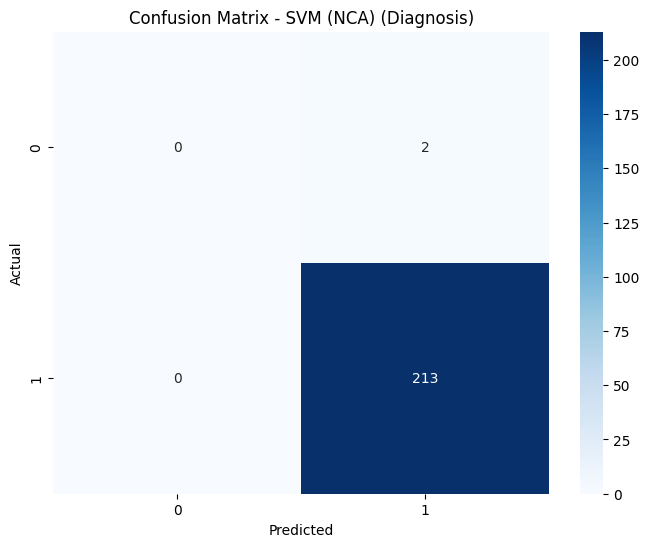


Stage Confusion Matrix saved to ../results/svm/svm_nca/svm_nca_stage_confusion_matrix.png


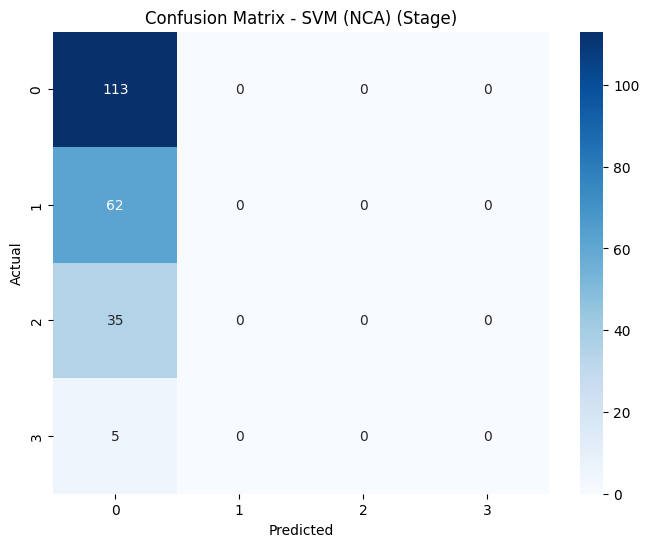


Subtype Confusion Matrix saved to ../results/svm/svm_nca/svm_nca_subtype_confusion_matrix.png


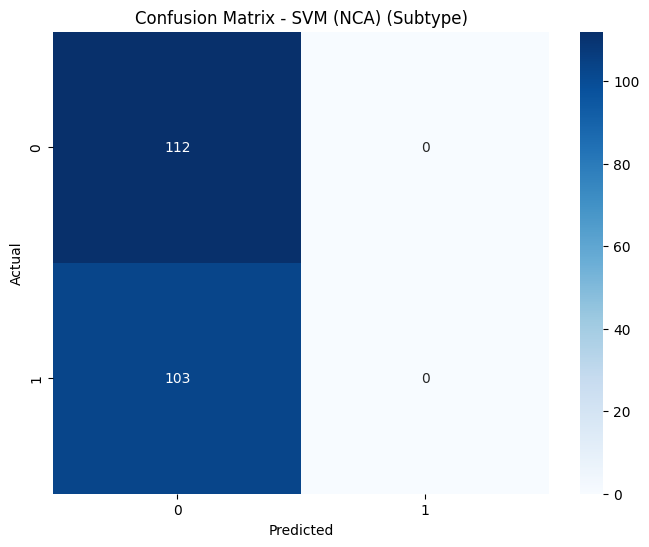


Top 10 Features Based on Maximum Variance:
['hsa-mir-4321', 'hsa-mir-8052', 'hsa-mir-761', 'hsa-mir-1184-2', 'hsa-mir-548aa-2', 'hsa-mir-4508', 'hsa-mir-4327', 'hsa-mir-548am', 'hsa-mir-548ad', 'hsa-mir-6752']

Top features saved to ../results/svm/svm_nca/svm_nca_top_features.txt

Diagnosis Correlation Matrix saved to ../results/svm/svm_nca/svm_nca_diagnosis_correlation_matrix.png


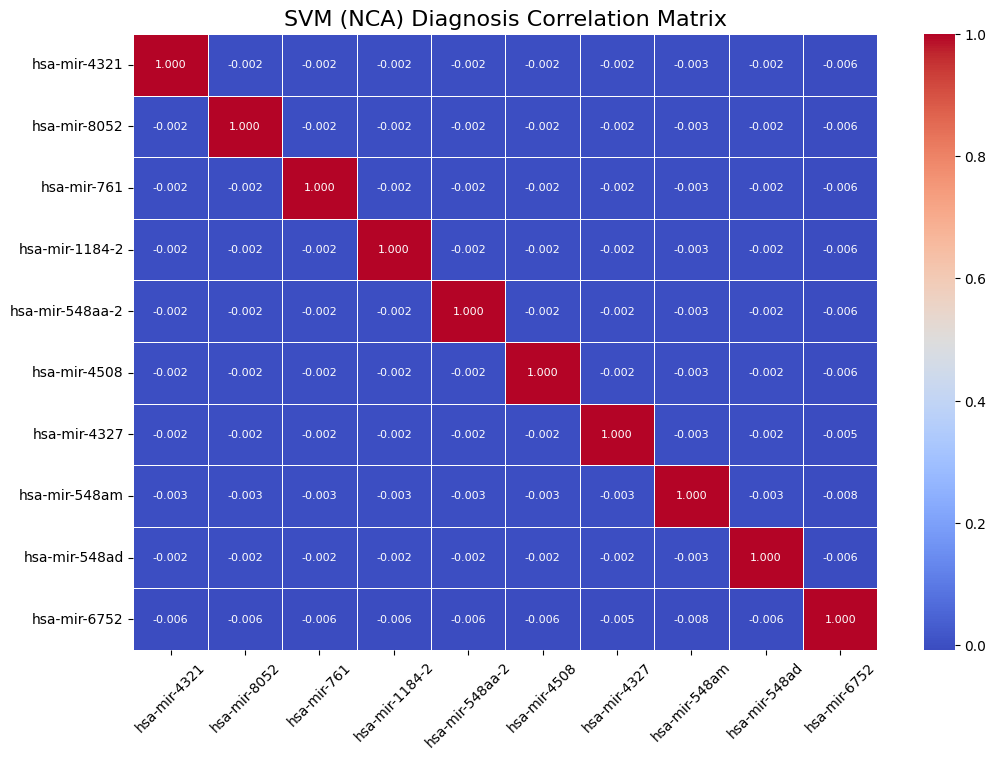


Diagnosis Covariance Matrix saved to ../results/svm/svm_nca/svm_nca_diagnosis_covariance_matrix.png


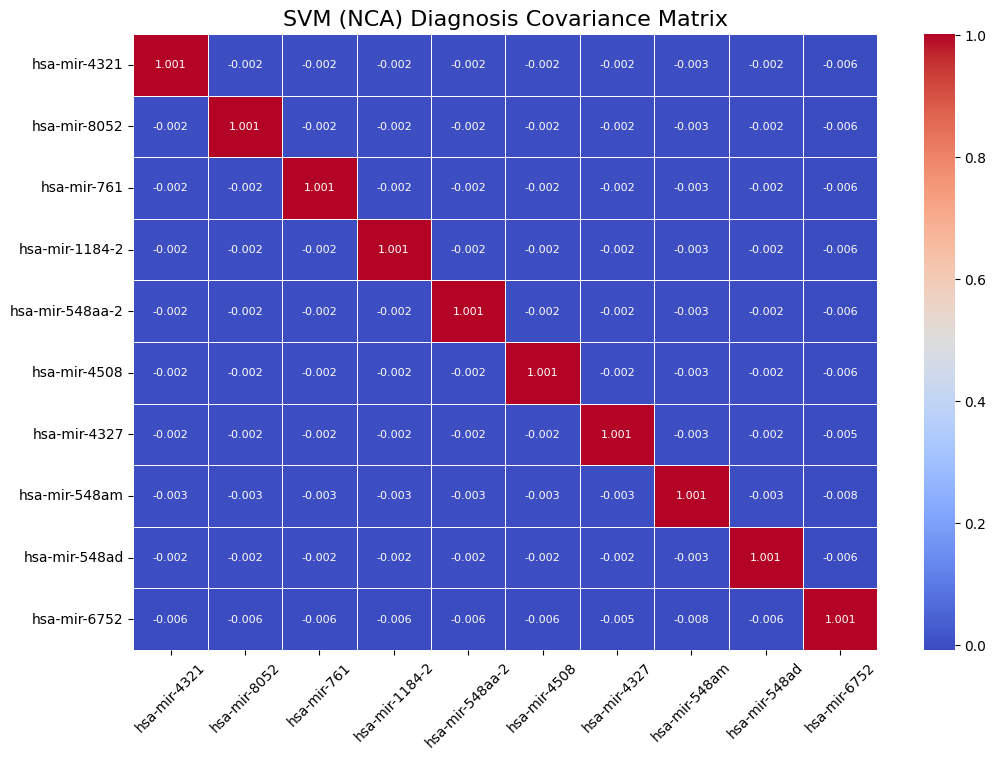


Stage Correlation Matrix saved to ../results/svm/svm_nca/svm_nca_stage_correlation_matrix.png


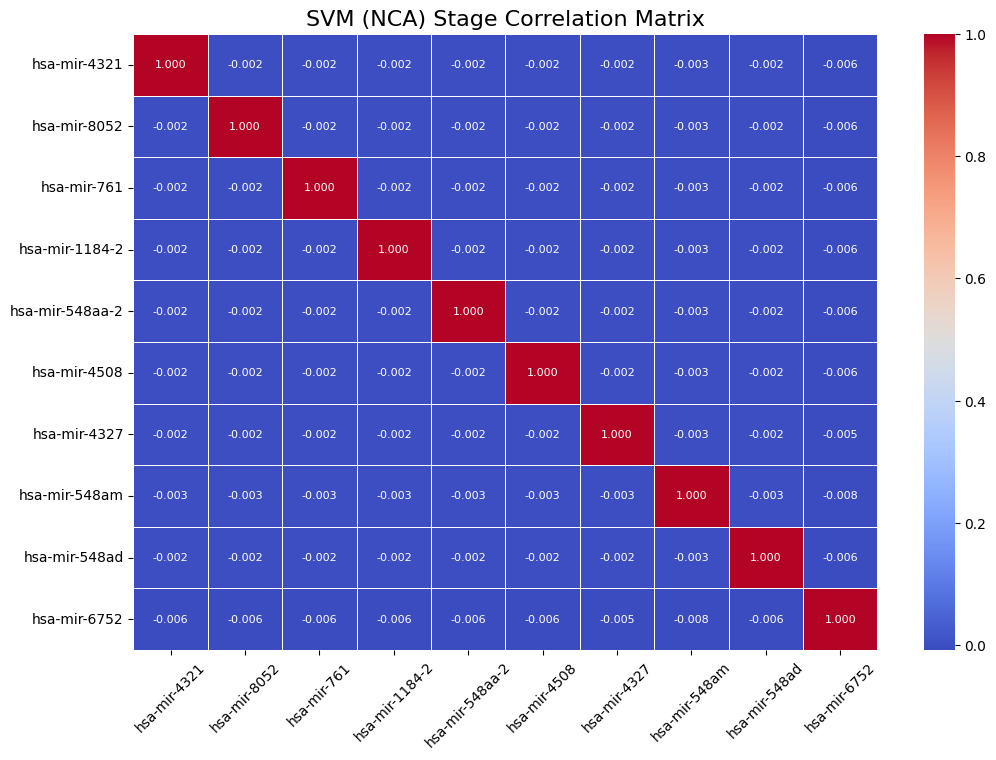


Stage Covariance Matrix saved to ../results/svm/svm_nca/svm_nca_stage_covariance_matrix.png


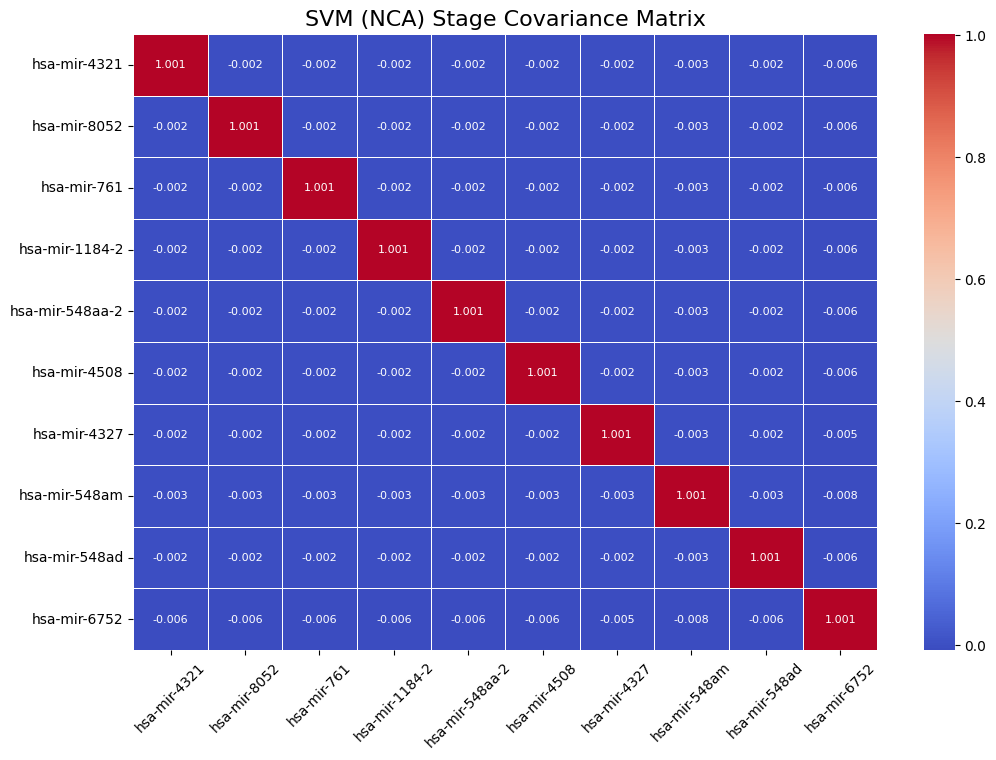


Subtype Correlation Matrix saved to ../results/svm/svm_nca/svm_nca_subtype_correlation_matrix.png


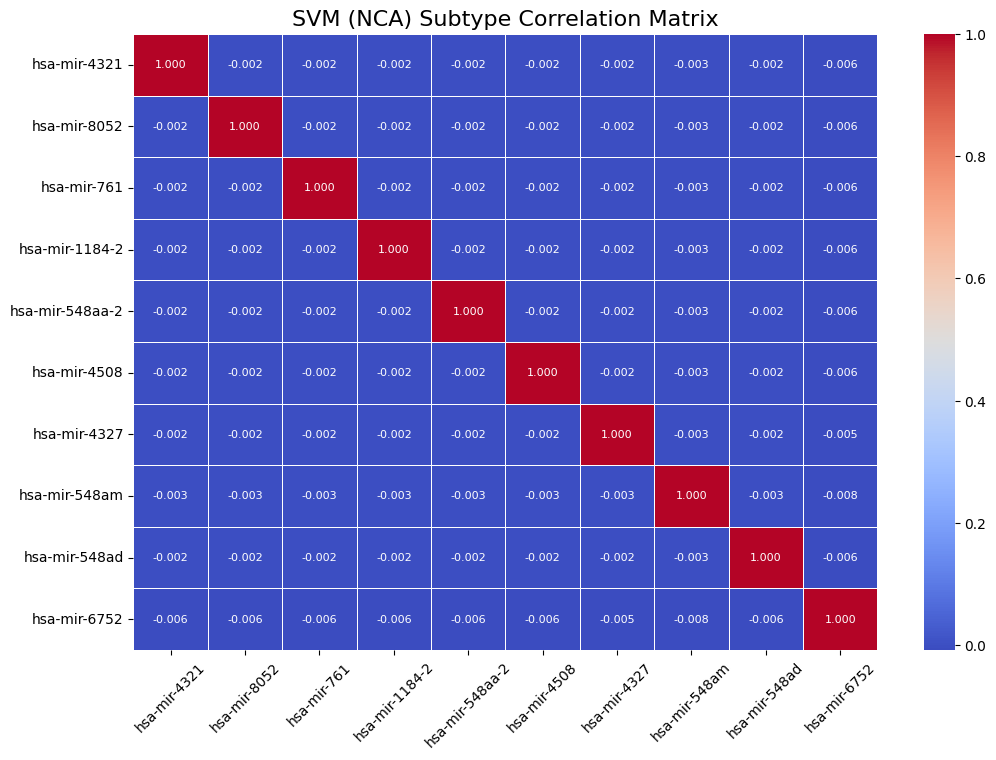


Subtype Covariance Matrix saved to ../results/svm/svm_nca/svm_nca_subtype_covariance_matrix.png


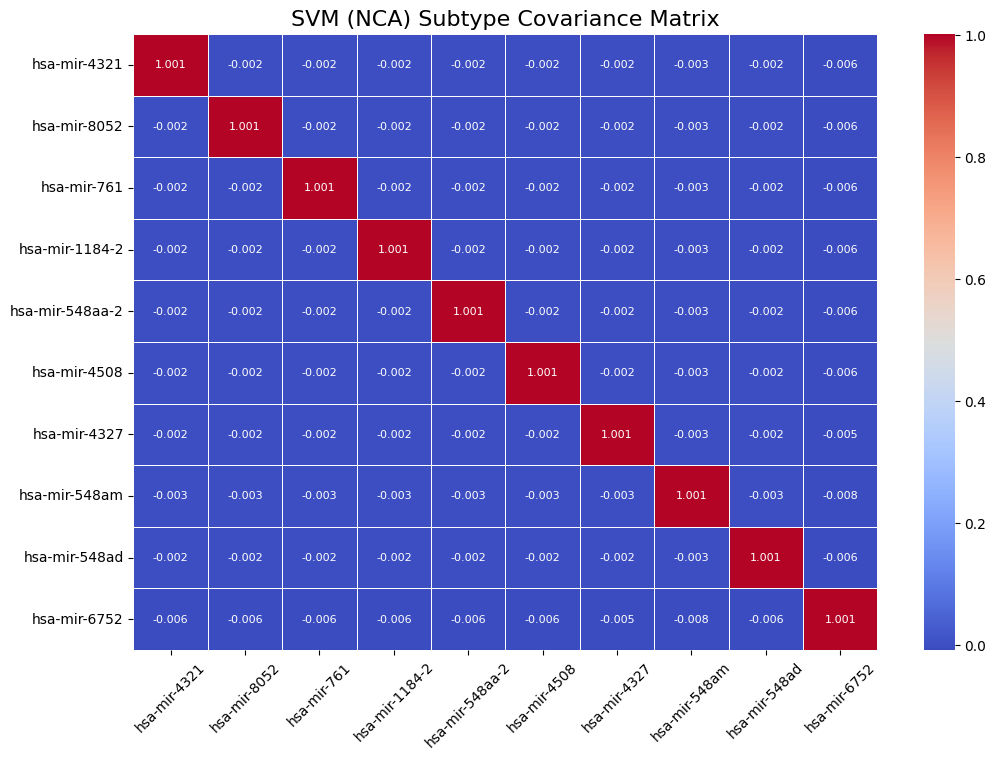

In [6]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import logging

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def evaluate_multioutput_model(y_test_diagnosis, y_test_stage, y_test_subtype, y_pred_diagnosis, y_pred_stage, y_pred_subtype, X_train, model_name="SVM (NCA)", save_dir="../results/svm/svm_nca/"):
    """
    Evaluate multi-output model performance for Diagnosis, Stage, and Subtype separately,
    including classification reports, confusion matrices, correlation, and covariance analysis.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

    # Convert to Pandas Series (fix potential NumPy array issues)
    y_test_diagnosis = pd.Series(y_test_diagnosis).reset_index(drop=True)
    y_test_stage = pd.Series(y_test_stage).reset_index(drop=True)
    y_test_subtype = pd.Series(y_test_subtype).reset_index(drop=True)
    y_pred_diagnosis = pd.Series(y_pred_diagnosis).reset_index(drop=True)
    y_pred_stage = pd.Series(y_pred_stage).reset_index(drop=True)
    y_pred_subtype = pd.Series(y_pred_subtype).reset_index(drop=True)

    # Ensure predictions and actual values have the same length
    min_length = min(len(y_test_diagnosis), len(y_pred_diagnosis), len(y_pred_stage), len(y_pred_subtype))
    y_test_diagnosis = y_test_diagnosis.iloc[:min_length].reset_index(drop=True)
    y_test_stage = y_test_stage.iloc[:min_length].reset_index(drop=True)
    y_test_subtype = y_test_subtype.iloc[:min_length].reset_index(drop=True)
    y_pred_diagnosis = y_pred_diagnosis.iloc[:min_length].reset_index(drop=True)
    y_pred_stage = y_pred_stage.iloc[:min_length].reset_index(drop=True)
    y_pred_subtype = y_pred_subtype.iloc[:min_length].reset_index(drop=True)

    # Define function for Sensitivity & Specificity Calculation
    def calculate_metrics(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):  # Binary classification
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 1.0  # Avoid NaN
        else:  # Multi-class classification
            recall_values = np.diag(cm) / np.sum(cm, axis=1)
            precision_values = np.diag(cm) / np.sum(cm, axis=0)
            sensitivity = np.nanmean(recall_values)  # Macro-average recall
            specificity = np.nanmean(precision_values)  # Macro-average specificity
        return sensitivity, specificity

    # Evaluate Diagnosis Classification
    diagnosis_accuracy = accuracy_score(y_test_diagnosis, y_pred_diagnosis)
    diagnosis_sensitivity, diagnosis_specificity = calculate_metrics(y_test_diagnosis, y_pred_diagnosis)
    diagnosis_cm = confusion_matrix(y_test_diagnosis, y_pred_diagnosis)
    diagnosis_report = classification_report(y_test_diagnosis, y_pred_diagnosis, zero_division=0)

    # Evaluate Stage Classification
    stage_accuracy = accuracy_score(y_test_stage, y_pred_stage)
    stage_sensitivity, stage_specificity = calculate_metrics(y_test_stage, y_pred_stage)
    stage_cm = confusion_matrix(y_test_stage, y_pred_stage)
    stage_report = classification_report(y_test_stage, y_pred_stage, zero_division=0)

    # Evaluate Subtype Classification
    subtype_accuracy = accuracy_score(y_test_subtype, y_pred_subtype)
    subtype_sensitivity, subtype_specificity = calculate_metrics(y_test_subtype, y_pred_subtype)
    subtype_cm = confusion_matrix(y_test_subtype, y_pred_subtype)
    subtype_report = classification_report(y_test_subtype, y_pred_subtype, zero_division=0)

    # Print evaluation results
    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    
    for label, acc, sens, spec, report in [
        ("Diagnosis", diagnosis_accuracy, diagnosis_sensitivity, diagnosis_specificity, diagnosis_report),
        ("Stage", stage_accuracy, stage_sensitivity, stage_specificity, stage_report),
        ("Subtype", subtype_accuracy, subtype_sensitivity, subtype_specificity, subtype_report)
    ]:
        print(f"\n{label} Classification:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Sensitivity (Recall): {sens:.4f}")
        print(f"Specificity: {spec:.4f}")
        print("\nClassification Report:\n", report)

    # Confusion Matrices (3)
    for label, cm, name in [("diagnosis", diagnosis_cm, "Diagnosis"),
                            ("stage", stage_cm, "Stage"),
                            ("subtype", subtype_cm, "Subtype")]:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {model_name} ({name})")

        cm_path = os.path.join(save_dir, f"svm_nca_{label}_confusion_matrix.png")
        plt.savefig(cm_path)
        print(f"\n{name} Confusion Matrix saved to {cm_path}")
        plt.show()

    # Top 10 Features Based on Maximum Variance
    top_variance_features = X_train.var().sort_values(ascending=False).index[:10]
    print("\nTop 10 Features Based on Maximum Variance:")
    print(top_variance_features.tolist())

    # Save top features
    top_features_path = os.path.join(save_dir, "svm_nca_top_features.txt")
    with open(top_features_path, "w") as f:
        for feature in top_variance_features:
            f.write(feature + "\n")
    print(f"\nTop features saved to {top_features_path}")

    # Correlation & Covariance Matrices (3 each)
    for label, matrix_name in [("diagnosis", "Diagnosis"), ("stage", "Stage"), ("subtype", "Subtype")]:
        selected_features = X_train[top_variance_features]  # Use same top 10 features
        correlation_matrix = selected_features.corr()
        covariance_matrix = selected_features.cov()

        for matrix, type_name in [(correlation_matrix, "correlation"), (covariance_matrix, "covariance")]:
            plt.figure(figsize=(12, 8))
            sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5, annot_kws={"size": 8})
            plt.title(f"{model_name} {matrix_name} {type_name.capitalize()} Matrix", fontsize=16)
            plt.xticks(fontsize=10, rotation=45)
            plt.yticks(fontsize=10)

            matrix_path = os.path.join(save_dir, f"svm_nca_{label}_{type_name}_matrix.png")
            plt.savefig(matrix_path)
            print(f"\n{matrix_name} {type_name.capitalize()} Matrix saved to {matrix_path}")
            plt.show()

    return {
        "diagnosis_accuracy": diagnosis_accuracy,
        "stage_accuracy": stage_accuracy,
        "subtype_accuracy": subtype_accuracy,
        "diagnosis_confusion_matrix": diagnosis_cm.tolist(),
        "stage_confusion_matrix": stage_cm.tolist(),
        "subtype_confusion_matrix": subtype_cm.tolist(),
    }

# Run Evaluation
save_dir = "../results/svm/svm_nca/"
metrics = evaluate_multioutput_model(y_test_diagnosis, y_test_stage, y_test_subtype, y_pred_diagnosis, y_pred_stage, y_pred_subtype, X_train, model_name="SVM (NCA)", save_dir=save_dir)


### Save Everything & Finalize the Pipeline (NCA)

In [7]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory for NCA Results
output_dir = "../results/svm/svm_nca/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Ensure `y_test` is properly assigned
if "y_test_stage" not in locals() or "y_test_subtype" not in locals():
    raise ValueError("`y_test_stage` or `y_test_subtype` is missing. Ensure variables are correctly assigned before running this block.")

# Ensure `y_pred_stage` and `y_pred_subtype` exist
if "y_pred_stage" not in locals() or "y_pred_subtype" not in locals():
    raise ValueError("Predictions (`y_pred_stage` or `y_pred_subtype`) are missing. Ensure models have made predictions.")

# Ensure predictions have the same length as `y_test`
min_length = min(len(y_test_stage), len(y_pred_stage), len(y_pred_subtype))
y_test_stage = y_test_stage.iloc[:min_length].reset_index(drop=True)
y_test_subtype = y_test_subtype.iloc[:min_length].reset_index(drop=True)
y_pred_stage = y_pred_stage[:min_length]
y_pred_subtype = y_pred_subtype[:min_length]

# Save Predictions & Actual Labels
y_pred_df = pd.DataFrame({
    "stage": y_pred_stage,
    "subtype": y_pred_subtype
}, index=y_test_stage.index)

predictions_path = os.path.join(output_dir, "svm_nca_predictions.csv")
y_pred_df.to_csv(predictions_path, index=False)
logging.info(f"Predictions saved to {predictions_path}")
print(f"Predictions saved to {predictions_path}")

actual_labels_path = os.path.join(output_dir, "svm_nca_actual_labels.csv")
y_test_combined = pd.DataFrame({
    "stage": y_test_stage,
    "subtype": y_test_subtype
})
y_test_combined.to_csv(actual_labels_path, index=False)
logging.info(f"Actual labels saved to {actual_labels_path}")
print(f"Actual labels saved to {actual_labels_path}")

# Save Experiment Metadata
metadata = {
    "stage_hyperparameters": grid_stage.best_params_ if "grid_stage" in locals() else "N/A",
    "subtype_hyperparameters": grid_subtype.best_params_ if "grid_subtype" in locals() else "N/A",
    "stage_accuracy": metrics["stage_accuracy"] if "metrics" in locals() else "N/A",
    "subtype_accuracy": metrics["subtype_accuracy"] if "metrics" in locals() else "N/A",
    "stage_confusion_matrix": metrics["stage_confusion_matrix"] if "metrics" in locals() else "N/A",
    "subtype_confusion_matrix": metrics["subtype_confusion_matrix"] if "metrics" in locals() else "N/A",
    "train_set_size": X_train.shape[0] if "X_train" in locals() else "N/A",
    "test_set_size": X_test.shape[0] if "X_test" in locals() else "N/A"
}

metadata_path = os.path.join(output_dir, "svm_nca_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")
print(f"Metadata saved to {metadata_path}")

# Save Separate Models for Stage & Subtype
if "best_svm_stage" in locals():
    model_stage_path = os.path.join(output_dir, "svm_nca_stage_model.pkl")
    joblib.dump(best_svm_stage, model_stage_path)
    logging.info(f"Stage model saved to {model_stage_path}")
    print(f"Stage model saved to {model_stage_path}")
else:
    logging.warning("`best_svm_stage` is missing. The model was not saved.")

if "best_svm_subtype" in locals():
    model_subtype_path = os.path.join(output_dir, "svm_nca_subtype_model.pkl")
    joblib.dump(best_svm_subtype, model_subtype_path)
    logging.info(f"Subtype model saved to {model_subtype_path}")
    print(f"Subtype model saved to {model_subtype_path}")
else:
    logging.warning("`best_svm_subtype` is missing. The model was not saved.")

print("\nAll results successfully saved. The SVM pipeline using NCA features is complete.")

2025-03-09 17:58:34,736 - INFO - Predictions saved to ../results/svm/svm_nca/svm_nca_predictions.csv
2025-03-09 17:58:34,738 - INFO - Actual labels saved to ../results/svm/svm_nca/svm_nca_actual_labels.csv
2025-03-09 17:58:34,739 - INFO - Metadata saved to ../results/svm/svm_nca/svm_nca_metadata.json
2025-03-09 17:58:34,744 - INFO - Stage model saved to ../results/svm/svm_nca/svm_nca_stage_model.pkl
2025-03-09 17:58:34,747 - INFO - Subtype model saved to ../results/svm/svm_nca/svm_nca_subtype_model.pkl


Predictions saved to ../results/svm/svm_nca/svm_nca_predictions.csv
Actual labels saved to ../results/svm/svm_nca/svm_nca_actual_labels.csv
Metadata saved to ../results/svm/svm_nca/svm_nca_metadata.json
Stage model saved to ../results/svm/svm_nca/svm_nca_stage_model.pkl
Subtype model saved to ../results/svm/svm_nca/svm_nca_subtype_model.pkl

All results successfully saved. The SVM pipeline using NCA features is complete.
